### Spaceship Titanic with fastai

Competition [Link](https://www.kaggle.com/competitions/spaceship-titanic/overview)

In [1]:
#|default_exp app

In [2]:
#The Following cell of code is used everytime FASTAI library is used.
#They tell the notebook to reload any changes made to any libraries used.
#They also ensure that any graphs are plotted are shown in this notebook
%reload_ext autoreload
%autoreload 2
%matplotlib inline

### Imports

In [3]:
from fastai.tabular.all import *
from fastbook import *
from pandas.api.types import is_string_dtype, is_numeric_dtype, is_categorical_dtype
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
import seaborn as sns
from dtreeviz.trees import *
from IPython.display import Image, display_svg, SVG
import dtreeviz

### Import Datasets and Create Dataframe

In [4]:
#| export
iskaggle = os.environ.get('KAGGLE_KERNEL_RUN_TYPE', '')
creds = ''

In [5]:
#| export
cred_path = Path('~/.kaggle/kaggle.json').expanduser()
if not cred_path.exists():
    cred_path.parent.mkdir(exist_ok=True)
    cred_path.write_text(creds)
    cred_path.chmod(0o600)

In [6]:
#| export
path = Path('spaceship-titanic')

In [7]:
#| export
if not iskaggle and not path.exists():
    import zipfile, kaggle
    kaggle.api.competition_download_cli(str(path))    
    zipfile.ZipFile(f'{path}.zip').extractall(path)

In [8]:
#| export
if iskaggle:
    path = Path('../input/spaceship-titanic')
    ! pip install -q dataset

Import CSV's as Pandas Dataframes

In [9]:
#| export
df = pd.read_csv(path/'train.csv', low_memory=False)
test_df = pd.read_csv(path/'test.csv', low_memory=False)
sample_df = pd.read_csv(path/'sample_submission.csv', low_memory=False)

In [10]:
df.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True


In [11]:
df['Transported'].value_counts()

True     4378
False    4315
Name: Transported, dtype: int64

Add a function to convert boolean values to 0 and 1 using `LabelEncoder` 

In [12]:
def bool_switch(df, col_name):
    encoder = LabelEncoder()
    df[f'{col_name}'] = encoder.fit_transform(df[f'{col_name}']) 

In [13]:
bool_switch(df, col_name='Transported')
bool_switch(df, col_name='VIP')
bool_switch(df, col_name='CryoSleep')


Check to see how it worked

In [14]:
df.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,0,B/0/P,TRAPPIST-1e,39.0,0,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,0
1,0002_01,Earth,0,F/0/S,TRAPPIST-1e,24.0,0,109.0,9.0,25.0,549.0,44.0,Juanna Vines,1
2,0003_01,Europa,0,A/0/S,TRAPPIST-1e,58.0,1,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,0
3,0003_02,Europa,0,A/0/S,TRAPPIST-1e,33.0,0,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,0
4,0004_01,Earth,0,F/1/S,TRAPPIST-1e,16.0,0,303.0,70.0,151.0,565.0,2.0,Willy Santantines,1


In [15]:
df['Transported'].value_counts()

1    4378
0    4315
Name: Transported, dtype: int64

In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   8693 non-null   object 
 1   HomePlanet    8492 non-null   object 
 2   CryoSleep     8693 non-null   int64  
 3   Cabin         8494 non-null   object 
 4   Destination   8511 non-null   object 
 5   Age           8514 non-null   float64
 6   VIP           8693 non-null   int64  
 7   RoomService   8512 non-null   float64
 8   FoodCourt     8510 non-null   float64
 9   ShoppingMall  8485 non-null   float64
 10  Spa           8510 non-null   float64
 11  VRDeck        8505 non-null   float64
 12  Name          8493 non-null   object 
 13  Transported   8693 non-null   int64  
dtypes: float64(6), int64(3), object(5)
memory usage: 950.9+ KB


In [17]:
df.columns

Index(['PassengerId', 'HomePlanet', 'CryoSleep', 'Cabin', 'Destination', 'Age',
       'VIP', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck',
       'Name', 'Transported'],
      dtype='object')

### Preparing Data

Declare dependant variable(y-axis)

In [18]:
#| export
dep_var = 'Transported'

In [19]:
df['Destination'].sample

<bound method NDFrame.sample of 0         TRAPPIST-1e
1         TRAPPIST-1e
2         TRAPPIST-1e
3         TRAPPIST-1e
4         TRAPPIST-1e
            ...      
8688      55 Cancri e
8689    PSO J318.5-22
8690      TRAPPIST-1e
8691      55 Cancri e
8692      TRAPPIST-1e
Name: Destination, Length: 8693, dtype: object>

Add tabular processes to transform categorical variables to something similar to `pd.Categorical`, and fill in missing/na values

In [20]:
#| export
procs = [Categorify, FillMissing]

Split our data set into a training(.8) and a validation(.2) set, set random_state to a fixed seed for consistency

In [21]:
#| export
train, valid = train_test_split(df, test_size=.2, random_state=42)

Check the sizes of the split

In [22]:
len(train), len(valid)

(6954, 1739)

Get an array of indexes for the training and validation sets

In [23]:
#| export
train_idx = np.array(train.index)
valid_idx = np.array(valid.index)
train_idx, valid_idx

(array([2333, 2589, 8302, ..., 5390,  860, 7270]),
 array([ 304, 2697, 8424, ..., 1302, 5934, 6093]))

Double check no duplicates

In [24]:
u, c = np.unique(valid_idx, return_counts=True)
dup = u[c > 1]
dup

array([], dtype=int64)

Pass `splits` a tuple of lists containing the training and validation indexes

In [25]:
#| export
splits = (list(train_idx), list(valid_idx))

Use `cont_cat_split` to separate continuous and categorical variables

In [26]:
#| export
cont, cat = cont_cat_split(df, 1, dep_var=dep_var)

Load our dataframe to a `TabularPandas` object, `procs` from above is applied here. Set the dependant variable as the target

In [27]:
to = TabularPandas(df, procs, cat, cont, y_names=dep_var, splits=splits)

In [28]:
len(to.train), len(to.valid)

(6954, 1739)

In [29]:
df['Transported'].sum()

4378

In [30]:
len(df)

8693

Pickle our tabular object so that we can skip a few steps in the future

In [31]:
save_pickle(path/'space_titan_to.pkl', to)

Load our Pickle file

In [32]:
to = load_pickle(path/'space_titan_to.pkl')

In [33]:
to.items['PassengerId']

2333    2334
2589    2590
8302    8303
8177    8178
500      501
        ... 
7175    7176
3187    3188
1302    1303
5934    5935
6093    6094
Name: PassengerId, Length: 8693, dtype: int16

In [34]:
to.items.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported,Age_na,RoomService_na,FoodCourt_na,ShoppingMall_na,Spa_na,VRDeck_na
2333,2334,1,0,0,3,28.0,0,0.0,55.0,0.0,656.0,0.0,5072,0,1,1,1,1,1,1
2589,2590,1,0,3953,3,17.0,0,0.0,1195.0,31.0,0.0,0.0,2014,0,1,1,1,1,1,1
8302,8303,2,1,933,1,28.0,0,0.0,0.0,0.0,0.0,0.0,427,1,1,1,1,1,1,1
8177,8178,3,0,3334,3,20.0,0,0.0,2.0,289.0,976.0,0.0,7876,1,1,2,1,1,1,1
500,501,2,1,720,1,36.0,0,0.0,0.0,0.0,0.0,0.0,37,1,1,1,1,1,1,1


In [36]:
to.train.xs

,PassengerId,HomePlanet,Cabin,Destination,Name,Age_na,RoomService_na,FoodCourt_na,ShoppingMall_na,Spa_na,VRDeck_na,CryoSleep,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck
2333,2334,1,0,3,5072,1,1,1,1,1,1,0,28.0,0,0.0,55.0,0.0,656.0,0.0
2589,2590,1,3953,3,2014,1,1,1,1,1,1,0,17.0,0,0.0,1195.0,31.0,0.0,0.0
8302,8303,2,933,1,427,1,1,1,1,1,1,1,28.0,0,0.0,0.0,0.0,0.0,0.0
8177,8178,3,3334,3,7876,1,2,1,1,1,1,0,20.0,0,0.0,2.0,289.0,976.0,0.0
500,501,2,720,1,37,1,1,1,1,1,1,1,36.0,0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5734,5735,1,6540,3,7676,1,1,1,1,1,1,2,18.0,0,14.0,2.0,144.0,610.0,0.0
5191,5192,3,2280,3,3858,1,1,1,1,1,1,0,50.0,2,690.0,0.0,30.0,762.0,428.0
5390,5391,1,2473,2,4569,1,1,1,1,1,1,0,22.0,0,158.0,0.0,476.0,0.0,26.0
860,861,3,3411,3,7121,1,1,1,1,1,1,0,34.0,0,379.0,0.0,1626.0,0.0,0.0


Assign our X values and Y value for training and validation

In [37]:
xs, y = to.train.xs, to.train.y
valid_xs, valid_y = to.valid.xs, to.valid.y

### Decision Tree Classifier

Test a small tree with 4 leaf nodes

In [38]:
m = DecisionTreeClassifier(max_leaf_nodes=4)
m.fit(xs, y);

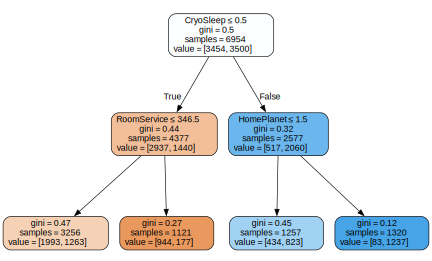

In [39]:
draw_tree(m, xs, size=6, leaves_parallel=True, precision=2)

Have the model run predictions on the validation set for who would be transported

In [41]:
y_pred = m.predict(valid_xs)

In [44]:
y_pred

array([0, 0, 1, ..., 0, 1, 0], dtype=int8)

Check how accurate our predictions were against the actual validation data

In [45]:
accuracy = accuracy_score(valid_y, y_pred)
accuracy

0.714203565267395

In [46]:
samp_idx = np.random.permutation(len(y))[:500]

In [47]:
viz_model = dtreeviz.model(m, X_train=xs.iloc[samp_idx], y_train=y.iloc[samp_idx], target_name=dep_var)

/home/petewin/mambaforge/lib/python3.10/site-packages/sklearn/base.py:409: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names


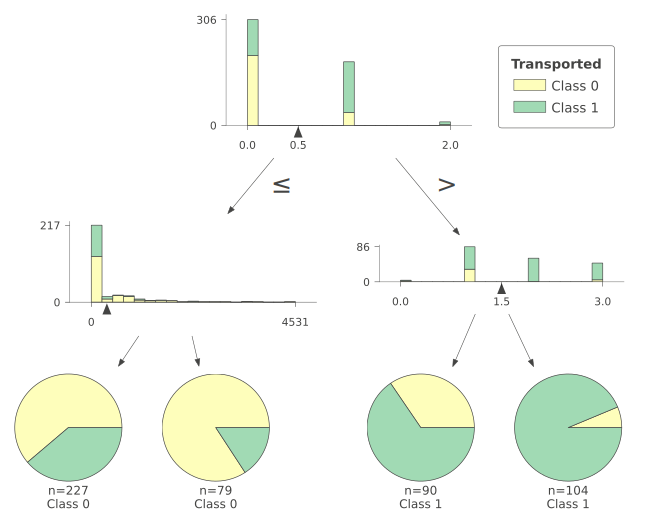

In [48]:
viz_model.view(fontname="DejaVu Sans", scale=1.8, label_fontsize=10)

In [49]:
viz_model = dtreeviz.model(m, X_train=xs, y_train=y, target_name=dep_var)

/home/petewin/mambaforge/lib/python3.10/site-packages/sklearn/base.py:409: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names


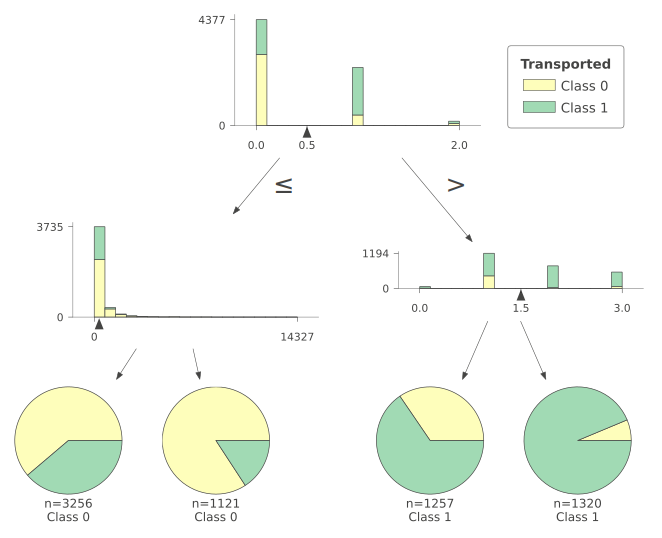

In [50]:
viz_model.view(fontname="DejaVu Sans", scale=1.8, label_fontsize=10)

### Logistic Regression

Run the same test with a quick logistic regression model

In [51]:
m = LogisticRegression(max_iter=1000)
m.fit(xs, y);

In [52]:
y_pred = m.predict(valid_xs)

In [53]:
accuracy = accuracy_score(valid_y, y_pred)
accuracy

0.7619321449108684

### All Leaves Decision Tree 

Run the same decision tree model, let it max out the leaves until there is one for each

In [54]:
m = DecisionTreeClassifier()
m.fit(xs, y);

In [55]:
y_pred = m.predict(valid_xs)

In [56]:
accuracy = accuracy_score(valid_y, y_pred)
accuracy

0.7245543415756182

In [57]:
m.get_n_leaves(), len(xs)

(1162, 6954)

### 25 Leaves Decision Tree 

Scale back to 25 Leaves as a happy medium

In [58]:
m = DecisionTreeClassifier(min_samples_leaf=25)
m.fit(xs, y);

In [59]:
y_pred = m.predict(valid_xs)

In [60]:
accuracy = accuracy_score(valid_y, y_pred)
accuracy

0.7751581368602645

### Random Forest

Create a function to make it easier to try several variations in succession

In [80]:
def rf(xs, y, n_estimators=40, max_features=0.5, min_samples_leaf=5, **kwargs):
    return RandomForestClassifier(n_jobs=-1, n_estimators=n_estimators,
        max_features=max_features, min_samples_leaf=min_samples_leaf, 
        oob_score=True).fit(xs,y)

In [81]:
m = rf(xs,y)

In [82]:
def pred_acc(m):
    y_pred = m.predict(valid_xs)
    accuracy = accuracy_score(valid_y, y_pred)
    return accuracy
    

In [83]:
pred_acc(m)

0.7929844738355377

In [85]:
preds = np.stack([t.predict(valid_xs.values) for t in m.estimators_])

ValueError: Classification metrics can't handle a mix of binary and continuous targets

In [89]:
valid_y.values

array([1, 0, 0, ..., 0, 1, 0], dtype=int8)